<div style="width: 400px; height: 160px;">
    <img src="rplogo_small.png" width="100%" height="100%" align="left">
</div>

###     TIPP - AAI Assignement (Deep Learning Fundamentals)<br>Due Date: 21 February 2020
###     Submitted By: <u>KOAY</u> SENG TIAN<br>Email: sengtian@yahoo.com


## Question 2 (Training)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# for reproducibility
np.random.seed(1337)

# set verbose=0 the skip the charts and other information
# set verbose=1 to see chart and other information
verbose=0
#verbose=1

# the datasets are stored in the data directory
data_dir = os.path.join(os.getcwd(), 'data')

# full path to datatraining.txt
datatraining_file = os.path.join(data_dir, 'datatraining.txt')

In [2]:
train_df = pd.read_csv(datatraining_file)
train_df['date']= pd.to_datetime(train_df['date']) 

if verbose==1:
    print(train_df.shape)
    print(train_df.head(5))
    print(train_df.tail(5))
    

In [3]:
train_df.sort_values(by='date', inplace=True, ascending=True)

if verbose==1:
    print('Training Data:')
    print('The time series starts from: ', train_df.date.min())
    print('The time series ends on: ', train_df.date.max())
    print()


In [4]:
if verbose==1:
    print('Columns having ZERO values:')
    print(train_df.eq(0).sum())
    print()

# Light has 5160 zero values - no issue since the light was switched off when there was no occupacy
# Occupancy has 6414 zero values - no issue since '0' represents unoccupied

In [5]:
import mycharts

In [6]:
if verbose==1:
    mycharts.chart01(train_df.columns[1:], train_df, 'black')
    

In [7]:
#set the dat as index
train_df = train_df.set_index('date')

# shift the data forward by 1
# to simulate the effect for future occupancy forecasting 
train_df = train_df.shift(1)

# drop the first row
train_df.drop(train_df.head(1).index, inplace=True)

if verbose==1:
    print('First row was dropped')
    print('Shape =', train_df.shape)
    

In [16]:
X = train_df.iloc[:,  : -1].copy().to_numpy()
y = train_df.iloc[:, -1].copy().to_numpy()


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# reshape due to LSTM's samples, timestep and features
X_train = X_train.reshape(-1, 1, 5)
X_test = X_test.reshape(-1, 1, 5)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [10]:
if verbose==1:
    print('X_train and X_test reshaped for LSTM:')
    print('X_train shape=', X_train.shape)
    print('X_test shape=', X_test.shape)

In [11]:
from keras import models
from keras import layers

data_dim = X_train.shape[2]
timesteps = X_train.shape[1]

network = models.Sequential()
network.add(layers.LSTM(32, return_sequences=True, input_shape=(timesteps, data_dim)))
network.add(layers.LSTM(32))
network.add(layers.Dense(1, activation='sigmoid'))

network.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

network.summary()


Using TensorFlow backend.






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 32)             4864      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,217
Trainable params: 13,217
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = network.fit(X_train, y_train, epochs=8, batch_size=50, verbose=1, shuffle=True, validation_data=(X_test, y_test))

print()
test_loss, test_acc = network.evaluate (X_test, y_test)
print('\ntest_acc:', test_acc)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 6513 samples, validate on 1629 samples
Epoch 1/8





6513/6513 [==============================] - 2s 309us/step - loss: 0.1958 - acc: 0.7858 - val_loss: 0.1362 - val_acc: 0.7876
Epoch 2/8
6513/6513 [==============================] - 1s 85us/step - loss: 0.0791 - acc: 0.8919 - val_loss: 0.0374 - val_acc: 0.9638
Epoch 3/8
6513/6513 [==============================] - 1s 81us/step - loss: 0.0330 - acc: 0.9635 - val_loss: 0.0242 - val_acc: 0.9785
Epoch 4/8
6513/6513 [==============================] - 1s 88us/step - loss: 0.0225 - acc: 0.9765 - val_loss: 0.0147 - val_acc: 0.9840
Epoch 5/8
6513/6513 [==============================] - 1s 91us/step - loss: 0.0157 - acc: 0.9859 - val_loss: 0.0102 - val_acc: 0.9920
Epoch 6/8
6513/6513 [==============================] - 1s 82us/step - loss: 0.0133 - acc: 0.9874 - val_loss: 0.0090 - val_acc: 0.9920
Epoch 7/8
6513/6513 [========================

In [13]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

epochs = range(1, len(loss_values) + 1)

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

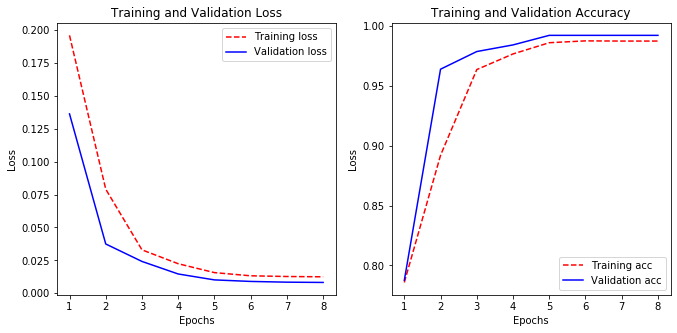

In [14]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

# draw chart to show validation vs training losses
ax1.plot(epochs, loss_values, 'r--', label='Training loss')
ax1.plot(epochs, val_loss_values, 'b', label='Validation loss')
ax1.title.set_text('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

# draw chart to show validation vs training accuracy
ax2.plot(epochs, acc_values, 'r--', label='Training acc')
ax2.plot(epochs, val_acc_values, 'b', label='Validation acc')
ax2.title.set_text('Training and Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()


In [15]:
# save model and scaler for later access
import pickle

save_dir = os.path.join(os.getcwd(), 'model')
model_filename = 'model.pkl'
scaler_filename = 'scaler.pkl'

with open(os.path.join(save_dir, model_filename), 'wb+') as model_file:
    pickle.dump(network, model_file)
    
with open(os.path.join(save_dir, scaler_filename), 'wb+') as scaler_file:
    pickle.dump(scaler, scaler_file)